In [4]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.16.1


In [5]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [6]:
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt

# Define paths to image directory and annotation file
image_path = r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset"
#dir_Flickr_text = r"C:\Users\pratd\Downloads\Flickr8k_text\Flickr8k.token.txt"
dir_Flickr_text = r"C:\vidisha\Flickr8k.token.txt"

# List files in the image directory
jpgs = os.listdir(image_path)
print("Total Images in Dataset =", len(jpgs))

Total Images in Dataset = 16182


In [7]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [8]:
## read in the Flickr caption data
text = load_doc(dir_Flickr_text)
print(text[:325])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .



In [9]:
def make_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [10]:
df = make_dataset(text)
df[:10]

[['1000268201_693b08cb0e.jpg',
  '0',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', '1', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  '2',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '3',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '4',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg',
  '0',
  'a black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  '1',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '2',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  '3',
  'two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '4',
  'two dogs on pavement moving t

In [11]:
data = pd.DataFrame(df,columns=["filename","index","caption"])
# Reordering columns for better readability
data = data.reindex(columns =['index','filename','caption'])

In [12]:
data

index                   filename  \
0         0  1000268201_693b08cb0e.jpg   
1         1  1000268201_693b08cb0e.jpg   
2         2  1000268201_693b08cb0e.jpg   
3         3  1000268201_693b08cb0e.jpg   
4         4  1000268201_693b08cb0e.jpg   
...     ...                        ...   
40455     0   997722733_0cb5439472.jpg   
40456     1   997722733_0cb5439472.jpg   
40457     2   997722733_0cb5439472.jpg   
40458     3   997722733_0cb5439472.jpg   
40459     4   997722733_0cb5439472.jpg   

                                                 caption  
0      a child in a pink dress is climbing up a set o...  
1                  a girl going into a wooden building .  
2       a little girl climbing into a wooden playhouse .  
3      a little girl climbing the stairs to her playh...  
4      a little girl in a pink dress going into a woo...  
...                                                  ...  
40455           a man in a pink shirt climbs a rock face  
40456           a man is rock climbing high in the air .  
40457  a person in a red shirt climbing up a rock fac...  
40458                    a rock climber in a red shirt .  
40459  a rock climber practices on a rock climbing wa...  

[40460 rows x 3 columns]

In [13]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))
        
'''
import re

def filter_invalid_filenames(data):
    valid_indices = [idx for idx, filename in enumerate(data["filename"]) if re.search(r"\_(\d+).jpg", filename)]
    return data.iloc[valid_indices]

# Call the function to filter out invalid filenames
data_filtered = filter_invalid_filenames(data)
'''

'\nimport re\n\ndef filter_invalid_filenames(data):\n    valid_indices = [idx for idx, filename in enumerate(data["filename"]) if re.search(r"\\_(\\d+).jpg", filename)]\n    return data.iloc[valid_indices]\n\n# Call the function to filter out invalid filenames\ndata_filtered = filter_invalid_filenames(data)\n'

In [14]:
invalid_filename_check(data)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


In [15]:
data[data['filename'] == "2258277193_586949ec62.jpg.1"]

index                     filename  \
6730     0  2258277193_586949ec62.jpg.1   
6731     1  2258277193_586949ec62.jpg.1   
6732     2  2258277193_586949ec62.jpg.1   
6733     3  2258277193_586949ec62.jpg.1   
6734     4  2258277193_586949ec62.jpg.1   

                                                caption  
6730                      people waiting for the subway  
6731  some people looking out windows in a large bui...  
6732     three people are waiting on a train platform .  
6733               three people standing at a station .  
6734  two woman and one man standing near train trac...

In [16]:
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
data.shape

(40455, 3)

In [17]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
  print("We can see that all the keys are having values count = 5")
  print(ct_dict)

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

In [18]:
unique_filenames = utility_counter(data)

The number of unique file names : 8091
We can see that all the keys are having values count = 5
Counter({'1000268201_693b08cb0e.jpg': 5, '1001773457_577c3a7d70.jpg': 5, '1002674143_1b742ab4b8.jpg': 5, '1003163366_44323f5815.jpg': 5, '1007129816_e794419615.jpg': 5, '1007320043_627395c3d8.jpg': 5, '1009434119_febe49276a.jpg': 5, '1012212859_01547e3f17.jpg': 5, '1015118661_980735411b.jpg': 5, '1015584366_dfcec3c85a.jpg': 5, '101654506_8eb26cfb60.jpg': 5, '101669240_b2d3e7f17b.jpg': 5, '1016887272_03199f49c4.jpg': 5, '1019077836_6fc9b15408.jpg': 5, '1019604187_d087bf9a5f.jpg': 5, '1020651753_06077ec457.jpg': 5, '1022454332_6af2c1449a.jpg': 5, '1022454428_b6b660a67b.jpg': 5, '1022975728_75515238d8.jpg': 5, '102351840_323e3de834.jpg': 5, '1024138940_f1fefbdce1.jpg': 5, '102455176_5f8ead62d5.jpg': 5, '1026685415_0431cbf574.jpg': 5, '1028205764_7e8df9a2ea.jpg': 5, '1030985833_b0902ea560.jpg': 5, '103106960_e8a41d64f8.jpg': 5, '103195344_5d2dc613a3.jpg': 5, '103205630_682ca7285b.jpg': 5, '10321

In [19]:
#Function to plot the images and its description
# https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[20:25]:
      #filename = image_path + '/' + jpgfnm
      filename = os.path.join(image_path, jpgfnm)

      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

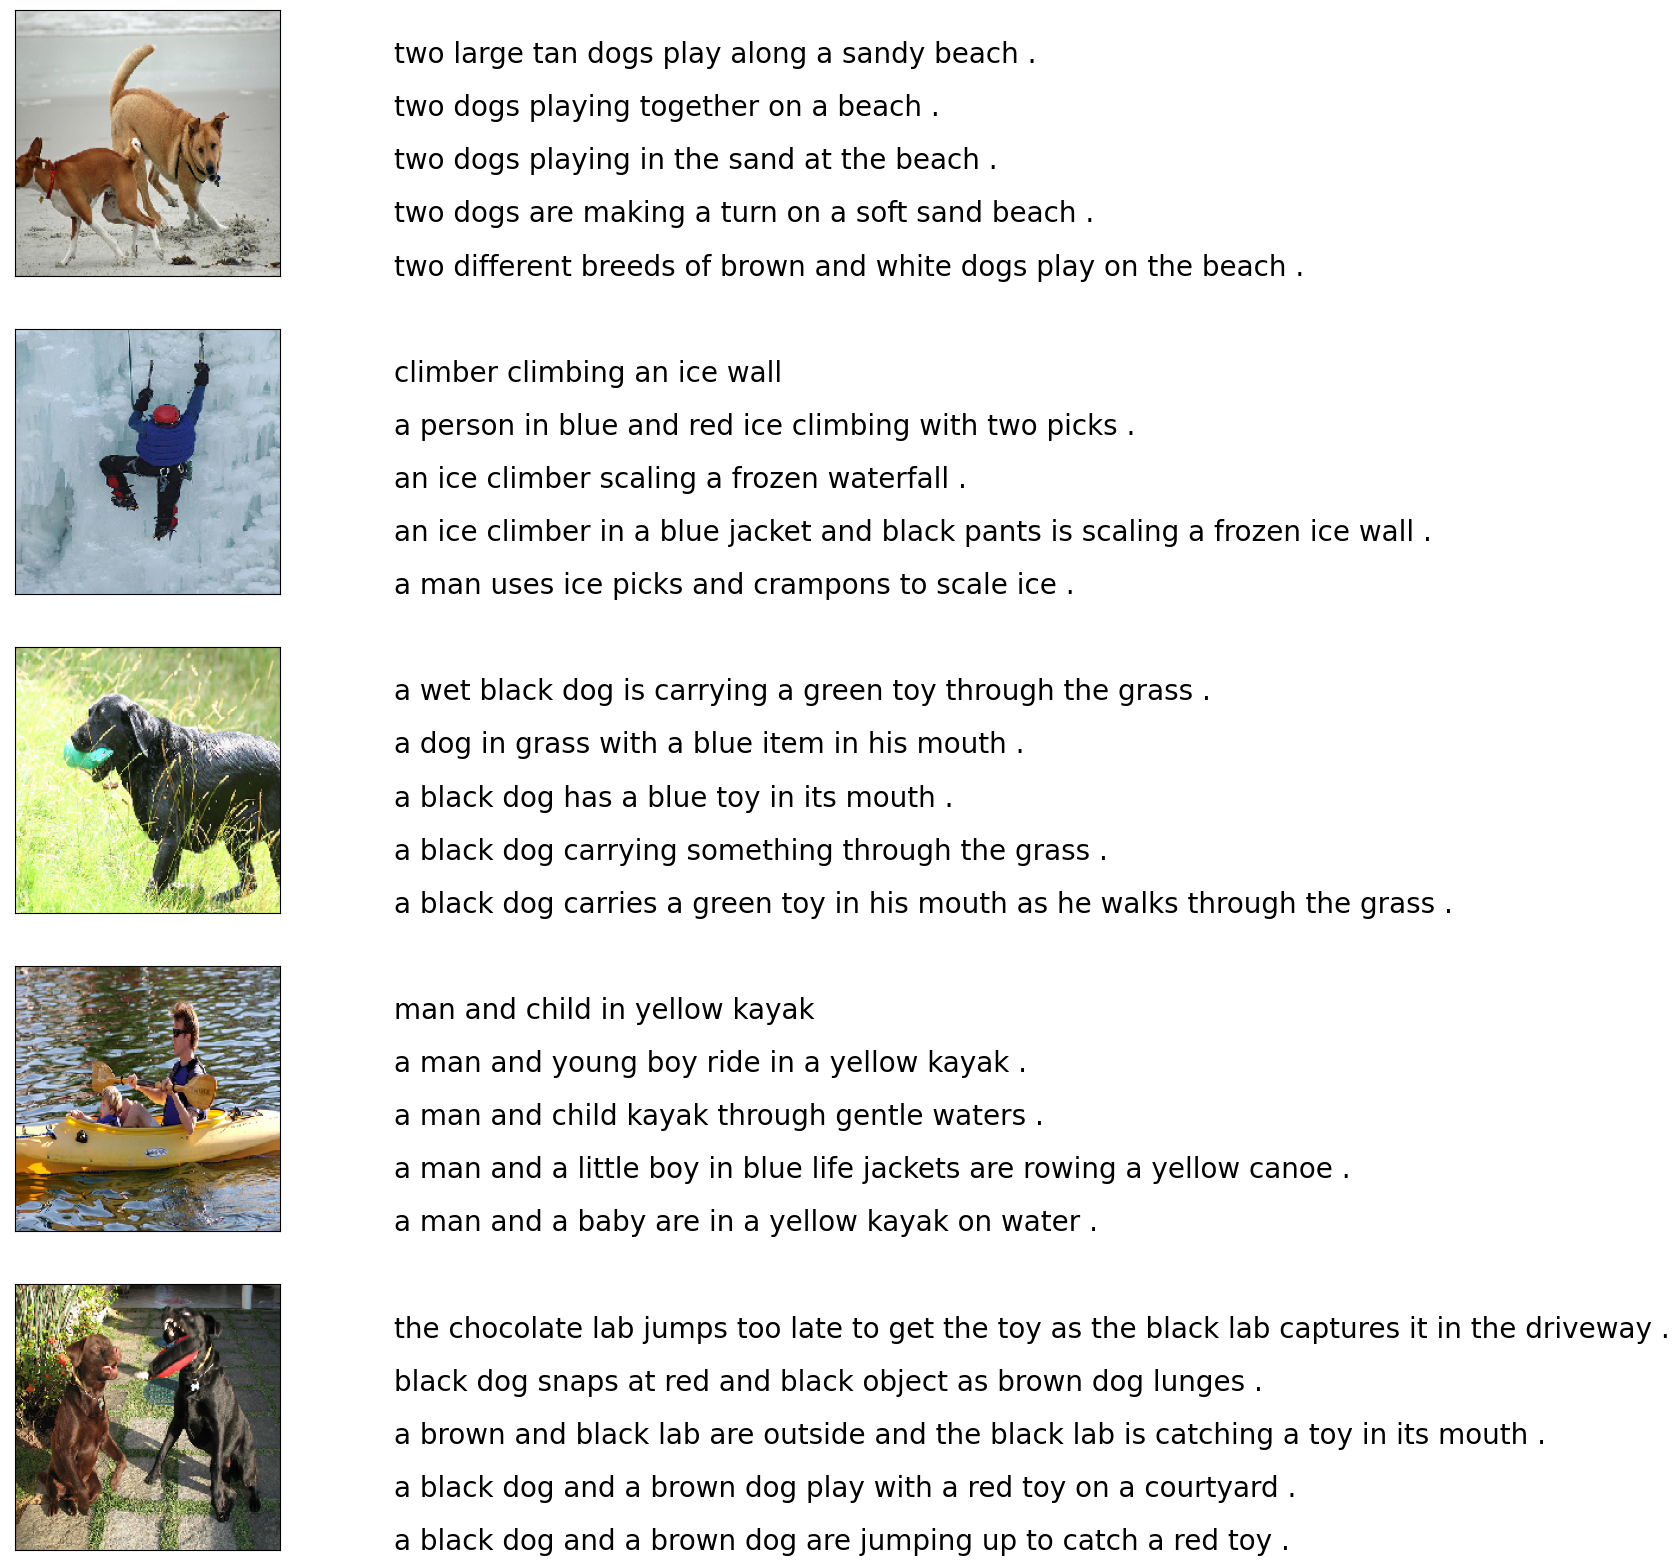

In [20]:
image_desc_plotter(data)

In [21]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [22]:
vocabulary = create_vocabulary(data)

Vocabulary Size : 8918


In [23]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [24]:
dfwordcount = df_word_count(data,vocabulary)

In [25]:
dfwordcount.iloc[:10,:]

word  count
0     a  62986
1     .  36577
2    in  18974
3   the  18418
4    on  10743
5    is   9345
6   and   8851
7   dog   8136
8  with   7765
9   man   7265

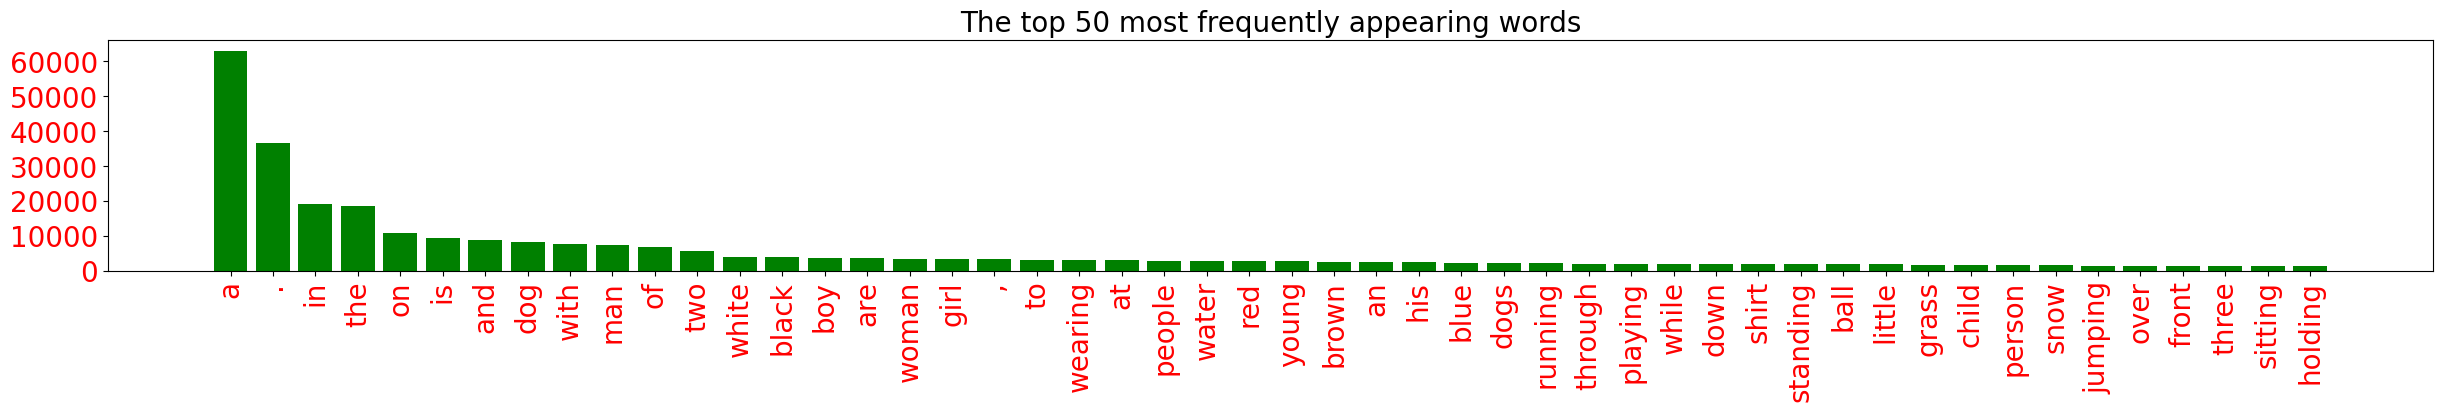

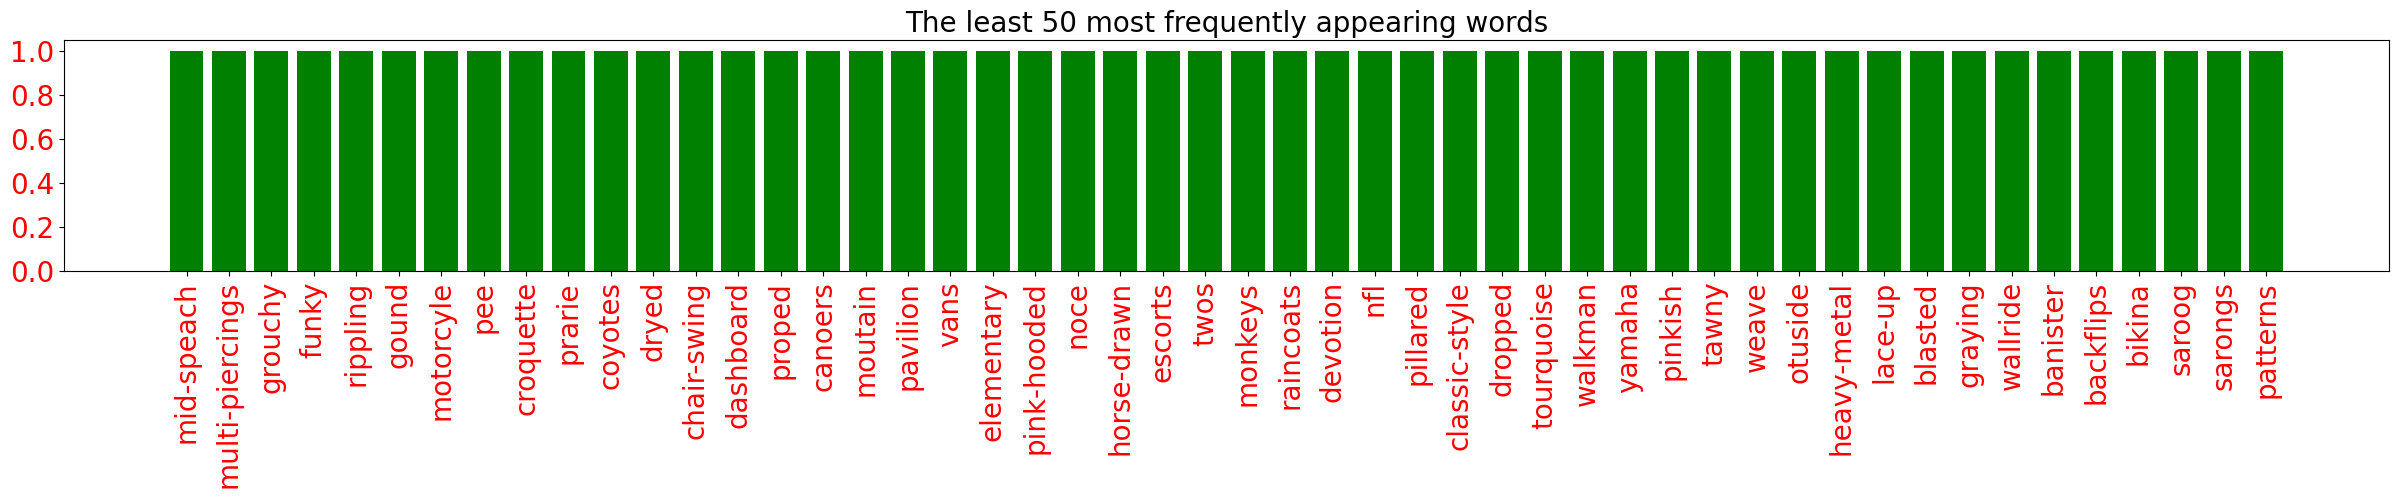

In [26]:

topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='g')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [27]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [28]:
clean_vocabulary = create_vocabulary(data)

Vocabulary Size : 8357


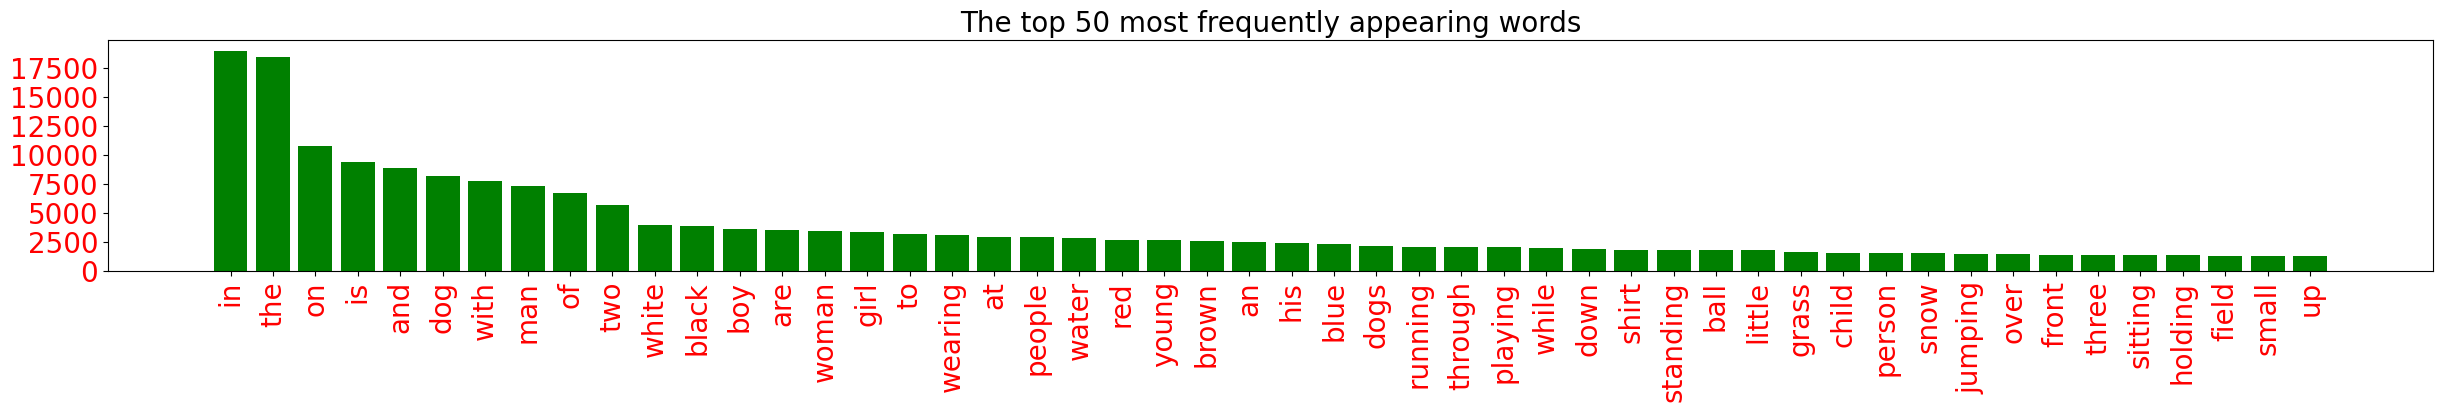

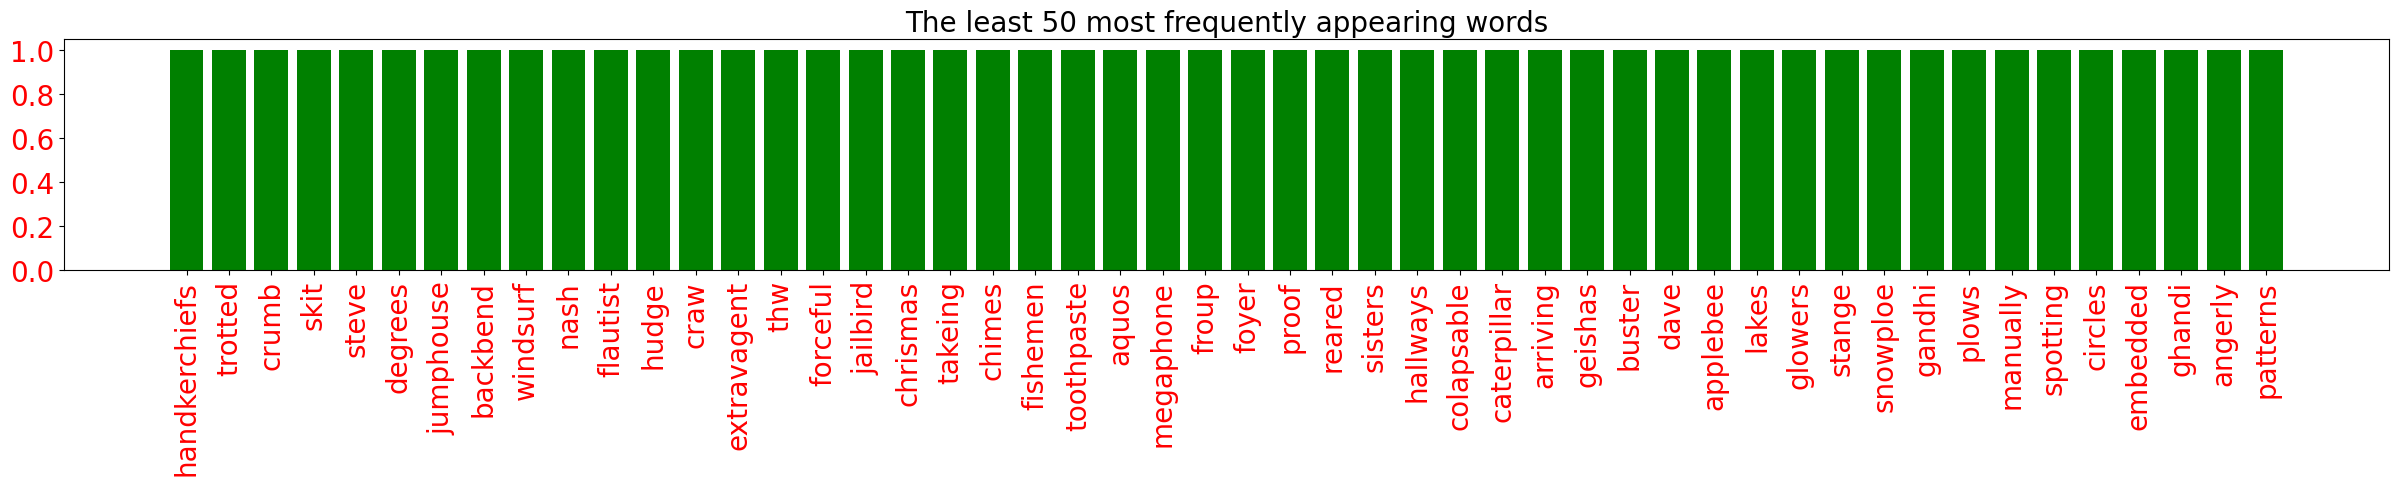

In [29]:
dfwordcount = df_word_count(data,clean_vocabulary)
plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [30]:
def preprocess_images(data):
  all_img_name_vector = []

  for filenames in data["filename"]:
      full_image_path = image_path+"/"+ filenames
      all_img_name_vector.append(full_image_path)
  return all_img_name_vector
all_img_name_vector = preprocess_images(data)
all_img_name_vector[:10]

['C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [31]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [32]:
ten_images = all_img_name_vector[:50] # Each image repeats 5 times in dataset
unique_images = np.unique(ten_images)
print(unique_images)

['C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1003163366_44323f5815.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1007129816_e794419615.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1007320043_627395c3d8.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1009434119_febe49276a.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1012212859_01547e3f17.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1015118661_980735411b.jpg'
 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']


In [33]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(ten_images):
    fig = figure()
    number_of_files = len(ten_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(ten_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

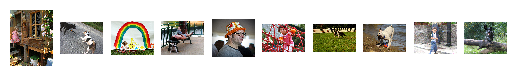

In [34]:
showImagesHorizontally(unique_images)

In [35]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40455
Total Captions : 40455


In [36]:
def data_limiter(num,total_captions,all_img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [37]:
train_captions,img_name_vector = data_limiter(40000,total_captions,all_img_name_vector)

In [38]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


In [39]:
from pickle import dump

# save to file
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))

In [40]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [41]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


In [42]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [43]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [44]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> 1956678973_223cb1b847.jpg is ==> (500, 375, 3)
Shape of the image ==> 3256603992_67312b5a36.jpg is ==> (375, 500, 3)
Shape of the image ==> 2938747424_64e64784f0.jpg is ==> (375, 500, 3)
Shape of the image ==> 2831314869_5025300133.jpg is ==> (400, 500, 3)
Shape of the image ==> 516725192_c9cdd63878.jpg is ==> (274, 500, 3)
Shape of the image ==> 537559285_29be110134.jpg is ==> (375, 500, 3)
Shape of the image ==> 2172493537_128bc8b187.jpg is ==> (334, 500, 3)
Shape of the image ==> 2287023569_fd7a9c60b8.jpg is ==> (500, 354, 3)
Shape of the image ==> 3191805046_77c334b506.jpg is ==> (500, 333, 3)
Shape of the image ==> 2869491449_1041485a6b.jpg is ==> (350, 500, 3)
Shape of the image ==> 140377584_12bdbdf2f8.jpg is ==> (375, 500, 3)
Shape of the image ==> 132489044_3be606baf7.jpg is ==> (375, 500, 3)
Shape of the image ==> 2346401538_f5e8da66fc.jpg is ==> (322, 500, 3)
Shape of the image ==> 181157221_e12410ef0b.jpg is ==> (375, 500, 3)
Shape of the image ==> 31

Shape of the image:(500, 357, 3)


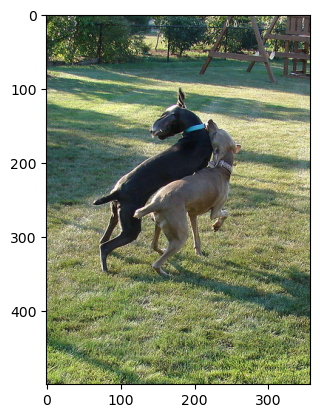

In [45]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes(r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset\957682378_46c3b07bcd.jpg")

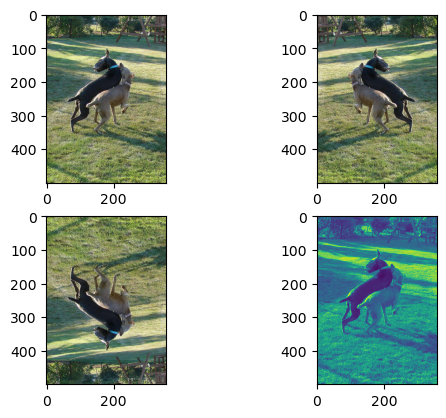

In [46]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

  #plt.imsave('doggo.jpg',flipped_img)

image_flipper(r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset\957682378_46c3b07bcd.jpg")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


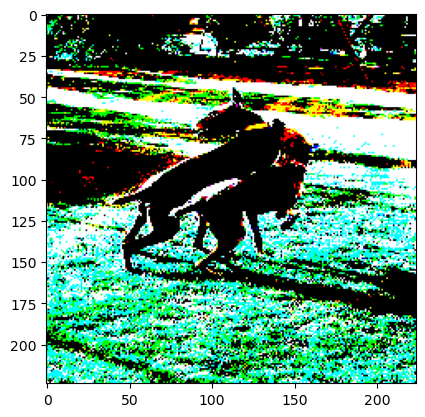

In [47]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image(r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset\957682378_46c3b07bcd.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [48]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes

In [49]:
modelvgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
'''
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
'''


from keras.applications import VGG16

# Path to the downloaded VGG16 weights file
weights_path = r"C:\Users\pratd\Downloads\vgg16_weights_tf_dim_ordering_tf_kernels.h5"

# Instantiate the VGG16 model with local weights file
image_model = VGG16(weights=weights_path, include_top=True)



# Get the output of the last layer you want to include
last_layer_output = image_model.get_layer('block5_pool').output

# Create a new model that includes layers up to block5_pool
image_features_extract_model = tf.keras.Model(inputs=image_model.input, 
                                               outputs=last_layer_output)

# Freeze the weights of the base model
#image_features_extract_model.trainable = False

# Summary of the new model
image_features_extract_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1003163366_44323f5815.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1007129816_e794419615.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1007320043_627395c3d8.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1009434119_febe49276a.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1015118661_980735411b.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']


In [52]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1003163366_44323f5815.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1007129816_e794419615.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1007320043_627395c3d8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1009434119_febe49276a.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1012212859_01547e3f17.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1015118661_980735411b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_D

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/221973402_ecb1cd51f1.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2219805467_370ee1b7aa.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2219805677_7b7cc188c7.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2219959872_988e6d498e.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2220175999_081aa9cce8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2220185725_45d4fa68d9.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2220612655_030413b787.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2221818690_9003756d33.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2222186636_85e03e0b75.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2222498879_9e82a100ab.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Da

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/269986132_91b71e8aaa.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2700147489_f1664f2b61.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2701042060_92508ea8fa.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2701271123_6761bc5f26.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2701487024_e866eb4550.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2701603045_6cbdc4ce7c.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2701895972_8605c4e038.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2702506716_17a7fb3ba4.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/270263570_3160f360d3.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2703155733_19ac6f97a8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dat

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3106787167_e5f2312622.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3106791484_13e18c33d8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3106857210_07a92577fc.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3106883334_419f3fb16f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3107059919_0594269f72.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/310715139_7f05468042.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/310728631_155c3bbeea.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3107368071_724613fc4f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3107463441_7c68606450.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3107513635_fe8a21f148.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dat

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/340425915_490293058f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3404408360_430f73b034.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3404552106_f516df0f5b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3404870997_7b0cd755de.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3404906655_bc51c69c1e.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3404978479_8a81843e17.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3405011838_f81117c99f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3405100926_e96308ce89.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3405113041_4b72c24801.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3405720825_b6991005eb.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Da

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3681056426_fbd6c0c92c.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3681172959_6674c118d2.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3681324243_b69fa90842.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3681414069_71ba164f71.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3681575323_433d007650.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3681651647_08eba60f89.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3682038869_585075b5ff.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/368212336_bc19b0bb72.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3682277595_55f8b16975.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3682428916_69ce66d375.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Da

In [53]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    path = files.numpy().replace(b'/', b'\\')
    print(path)


b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1000268201_693b08cb0e.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1001773457_577c3a7d70.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1003163366_44323f5815.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1007129816_e794419615.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1007320043_627395c3d8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1009434119_febe49276a.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1012212859_01547e3f17.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1015118661_980735411b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\F

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2244024374_54d7e88c2b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2244171992_a4beb04d8e.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2244551043_21b8cca866.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2244613488_4d1f9edb33.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2245348304_08bc5642f1.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2245618207_fa486ba2b7.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2245914678_1f82fc3d80.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2245916742_73af13c733.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2246717855_c0c08fe5d2.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\224702241_05af393148.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Fl

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2674784195_704f6b79d0.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2675190069_d5c3b2c876.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2675397335_1dcdbd12f5.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2675685200_0913d84d9b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2676015068_690b0fb2cd.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2676184321_858eff416b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2676648667_cb055b4fc6.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2676649969_482caed129.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2676651833_3bb42bbb32.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\2676764246_c58205a365.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\F

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3085667865_fa001816be.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3085973779_29f44fbdaa.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3086507638_d8a2cd0ac3.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3086523890_fd9394af8b.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3086526292_f799d237c7.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3086790344_9487c58624.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3086810882_94036f4475.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3087095548_6df7c2a8ed.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3087485737_cb09bc80b6.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3088074124_481139dc92.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\F

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3367053761_8ec5834bf3.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3367758711_a8c09607ac.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3367851138_757d6bd2ef.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3368207495_1e2dbd6d3f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3368569524_a9df2fc312.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3368671163_0171259581.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3368819708_0bfa0808f8.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3368865171_597d51cdd5.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3369258147_03db257f0f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3369354061_2bab79f91f.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\F

b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3690348036_a01f243fb0.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3690425778_3b390b3ea5.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3690431163_1d81e19549.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\369047365_35476becc9.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3690883532_d883f34617.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3691592651_6e4e7f1da9.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3691622437_f13644273c.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3691670743_0ed111bcf3.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3691729694_2b97f14c1e.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset\\3691800116_6a7b315e46.jpg'
b'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Fl

In [54]:
# Feel free to change batch_size according to your system configuration
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [55]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [56]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|                                                                                          | 0/127 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [57]:
np_img =np.load(r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset\96973080_783e375945.jpg.npy")

In [58]:
print(np_img)
print("Shape : {}".format(np_img.shape))

[[ 0.         0.         0.        ...  0.        10.7613945  0.       ]
 [ 0.         0.         0.        ...  0.         5.813175   0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
Shape : (49, 512)


# Data Preprocessing for a Language Generation(RNN) Decoder

We will perform a few basic pre-processing steps on the captions such as:
   -> First, we will tokenize the captions. This will help us to build a vocabulary of all the unique words in the data.
   -> Next, we will limit the vocabulary size to top 5000 words to save memory. We will replace all the other words with the           token < unk > (for words not in vocabulary) . You , can obviously optimize that according to the use cases.
   ->Finally, we will create a word->index mapping and vice versa.
   -> We will pad all sequences to be the same length as the longest one.

 Tokenizer object in TensorFlow's Keras API:
 
The "word index" refers to a dictionary that maps words (or tokens) to integer indices. When you fit the tokenizer on a corpus of text data using the fit_on_texts method, it builds this word index based on the unique words present in the text corpus.

For example, if you have the following text corpus:
["the cat sat on the mat", "the dog played in the yard"]

After fitting the tokenizer, the word index might look like this:
{
    'the': 1,
    'cat': 2,
    'sat': 3,
    'on': 4,
    'mat': 5,
    'dog': 6,
    'played': 7,
    'in': 8,
    'yard': 9,
    '<unk>': 10  # This is for out-of-vocabulary (OOV) words
}
Here, each word is assigned a unique integer index. The special token <unk> is used to represent out-of-vocabulary words encountered during text-to-sequence conversion.

The word index is used internally by the Tokenizer object to convert text data into sequences of integers and vice versa. When you call texts_to_sequences or texts_to_matrix methods, the tokenizer looks up each word in the word index and replaces it with its corresponding integer index. Conversely, when you call sequences_to_texts, it uses the word index to reverse the process and convert sequences of integers back into text.


In [59]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

tokenizer.fit_on_texts(train_captions): This method updates the internal vocabulary of the tokenizer based on the given train_captions. It creates a word index where each word in the corpus is assigned a unique integer index. This method is used to prepare the tokenizer for encoding text data into sequences of integers.

tokenizer.texts_to_sequences(train_captions): This method converts the input train_captions (which is a list of strings) into sequences of integers based on the word index learned during the fitting process. Each word in the captions is replaced by its corresponding integer index according to the word index generated by fit_on_texts. The resulting train_seqs is a list of lists, where each inner list represents the sequence of integer indices corresponding to a caption in train_captions.

Next 2 lines:-
These lines are manually mapping the special token <pad> to the integer index 0 in the word index dictionary (tokenizer.word_index) and mapping the integer index 0 back to the special token <pad> in the reverse word index dictionary (tokenizer.index_word). This is a common practice in natural language processing tasks where sequences need to be padded to a fixed length. 

In [60]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [61]:
train_seqs[:3] # Here we can see that the sentences are converted to sequences

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [62]:
# oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
tokenizer.oov_token

'<unk>'

In [63]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'at',
 23: 'people',
 24: 'water',
 25: 'red',
 26: 'young',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'shirt',
 38: 'standing',
 39: 'ball',
 40: 'little',
 41: 'grass',
 42: 'child',
 43: 'person',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'front',
 48: 'three',
 49: 'sitting',
 50: 'holding',
 51: 'field',
 52: 'small',
 53: 'up',
 54: 'by',
 55: 'large',
 56: 'green',
 57: 'one',
 58: 'group',
 59: 'yellow',
 60: 'her',
 61: 'walking',
 62: 'children',
 63: 'men',
 64: 'into',
 65: 'air',
 66: 'beach',
 67: 'near',
 68: 'mouth',
 69: 'jumps',
 70: 'another',
 71: 'for',
 72: 'street',
 73: 'its',
 74: 'runs',
 75: 'from

In [64]:
tokenizer.word_counts

OrderedDict([('<start>', 40000),
             ('several', 308),
             ('children', 1136),
             ('leaping', 138),
             ('into', 1067),
             ('pile', 74),
             ('of', 6632),
             ('leaves', 139),
             ('on', 10622),
             ('the', 18232),
             ('ground', 355),
             ('<end>', 40000),
             ('man', 7193),
             ('hiking', 63),
             ('in', 18771),
             ('wilderness', 6),
             ('giving', 34),
             ('camera', 685),
             ('thumbs', 19),
             ('up', 1244),
             ('white', 3896),
             ('dog', 8046),
             ('is', 9266),
             ('running', 2049),
             ('through', 2012),
             ('water', 2757),
             ('onto', 211),
             ('shore', 169),
             ('young', 2598),
             ('relaxing', 15),
             ('his', 2327),
             ('legs', 130),
             ('pice', 1),
             ('machinery', 1),

In [65]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [66]:
# Find the minimum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [67]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


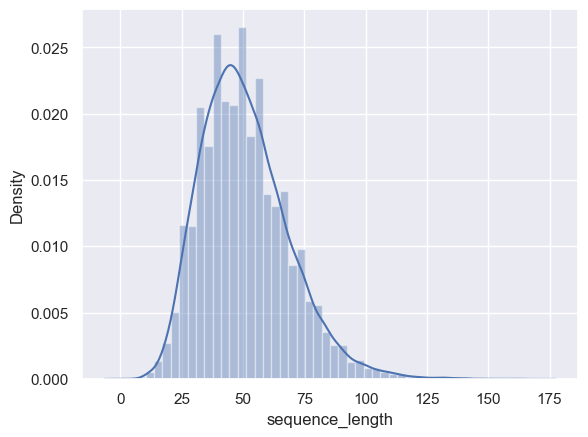

In [68]:
import seaborn as sns

df=pd.DataFrame()
df["sequence_length"] = data["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

# Pad each vector to the max_length of the captions, so that all caption vectors are of same length

In [69]:
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector

In [70]:
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(40000, 33)


In [71]:
padded_caption_vector

array([[  2, 184,  62, ...,   0,   0,   0],
       [  2,  11, 588, ...,   0,   0,   0],
       [  2,  14,   9, ...,   0,   0,   0],
       ...,
       [  2,  19,   4, ...,   0,   0,   0],
       [  2,  16,   4, ...,   0,   0,   0],
       [  2, 153,   9, ...,   0,   0,   0]])

# Train-Test split: 80-20

 splitting the image names (img_name_vector) and padded captions (padded_caption_vector) into training and testing sets using an 80-20 split. Here's a breakdown of what each variable represents:

1. img_name_train: Training set of image names
2. img_name_test: Testing set of image names
3. caption_train: Training set of padded captions
4. caption_test: Testing set of padded captions

The train_test_split function from the sklearn.model_selection module is used for this purpose, with a test size of 0.2, indicating an 80-20 split. The random_state parameter is set to 0 for reproducibility.

In [72]:
# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

In [73]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 32000,Y = 32000
Test Data : X = 8000,Y = 8000


In [74]:
print(img_name_test)

['C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2352414953_10f3cd0f1f.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3081182021_22cfa18dd4.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3104909823_0f41dd8be6.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2956413620_d59de03a06.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/1501297480_8db52c15b0.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2285741931_07159a21f2.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2258951972_92763fddab.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3537520829_aab733e16c.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/3404552106_f516df0f5b.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_Dataset/2463067409_78188c584c.jpg', 'C:\\Users\\pratd\\Downloads\\Flickr8k_Dataset\\Flicker8k_D

#Creating the dataset: loading .npy files 

In [75]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [76]:
def load_npy(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [77]:
'''
# How Dataset.from_tensor_slices work
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensor_slices(t)   # [1, 2], [3, 4]
ds # <TensorSliceDataset shapes: (2,), types: tf.int32>
'''
def create_dataset(img_name_train,caption_train):

  
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset


In [78]:
# Creating train and test dataset
dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [79]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500   (no. of training steps per epoch)
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49 

# CNN Encoder

 CNN ENCODER -->  the single fully connected layer followed by ReLU activation

In [80]:
# https://www.tensorflow.org/tutorials/text/image_captioning
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x   


The VGG16_Encoder takes the output of a pre-trained VGG16 model and passes it through a fully connected layer. Here's a breakdown of the class:

Initialization: The __init__ method initializes the encoder. It takes an embedding_dim parameter, which represents the dimensionality of the output embedding. Inside this method, a fully connected layer (self.fc) is defined with the specified embedding dimension.

call Method: The call method defines the forward pass of the encoder. It takes the input x, which represents the output features from the pre-trained VGG16 model. Inside the method, the input x is passed through the fully connected layer (self.fc). Then, the ReLU activation function is applied to the output to introduce non-linearity.

Dropout Layer (Optional): There is a dropout layer (self.dropout) commented out in the code. Dropout is a regularization technique commonly used to prevent overfitting in neural networks by randomly setting a fraction of input units to zero during training. If you want to use dropout, you can uncomment this layer and apply dropout to the input features before passing them through the fully connected layer.

In [81]:
'''
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')
                                   '''


def rnn_type(units):
    # Check if a GPU is available
    if tf.test.is_gpu_available():
        # If GPU is available, return CuDNNLSTM
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        # If GPU is not available, return unidirectional LSTM
        return tf.keras.layers.LSTM(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')



In [82]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and 
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism 
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn
    
    
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)

    
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    
    
    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)
    
    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))
    


In [83]:
'''
class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.units,
                                               return_sequences=True,
                                               return_state=True,
                                               recurrent_initializer='glorot_uniform'))

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5)
        self.batchnormalization = tf.keras.layers.BatchNormalization()

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        #score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(tf.transpose(hidden_with_time_axis, perm=[0, 2, 1]))))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, forward_state, backward_state = self.lstm(x)

        state = tf.concat([forward_state, backward_state], axis=-1)

        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.dropout(x)
        x = self.batchnormalization(x)

        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units))] * 2
        '''


"\nclass Rnn_Local_Decoder(tf.keras.Model):\n    def __init__(self, embedding_dim, units, vocab_size):\n        super(Rnn_Local_Decoder, self).__init__()\n        self.units = units\n\n        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)\n        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.units,\n                                               return_sequences=True,\n                                               return_state=True,\n                                               recurrent_initializer='glorot_uniform'))\n\n        self.fc1 = tf.keras.layers.Dense(self.units)\n\n        self.dropout = tf.keras.layers.Dropout(0.5)\n        self.batchnormalization = tf.keras.layers.BatchNormalization()\n\n        self.fc2 = tf.keras.layers.Dense(vocab_size)\n\n        # Implementing Attention Mechanism\n        self.Uattn = tf.keras.layers.Dense(units)\n        self.Wattn = tf.keras.layers.Dense(units)\n        self.Vattn = tf.keras.layers.D

# axis=-1: Specifies the axis along which batch normalization is applied. By default, -1 refers to the last axis, typically the channel axis in convolutional layers.

momentum=0.99: Momentum for the moving mean and moving variance computation. It determines the exponential decay rate for the moving averages.

epsilon=0.001: A small constant added to the variance of each mini batch to avoid division by zero.

center=True: If True, adds a trainable offset parameter to the normalized output. It centers the data around zero mean.This offset parameter is added to the normalized activations after they have been centered around zero mean. The purpose of this offset is to provide flexibility to the model in case it needs to shift the distribution of the activations away from zero.

scale=True: If True, adds a trainable scale parameter to the normalized output. It scales the normalized data.



In [84]:
''' Type: 'global' for Luong's Attention Mechanism(Global Attention) 
    Type: 'local' for Bahdanau's Attention Mechanism(Local Attention) 
'''
attention_choice = input("Choose the type of Attention Mechanism you want to apply :")

Choose the type of Attention Mechanism you want to apply :local


In [85]:
if(attention_choice=='local'):
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

else:
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Global_Decoder(embedding_dim, units, vocab_size,scoring_type)


In [86]:
decoder

<Rnn_Local_Decoder name=rnn__local__decoder, built=False>

In [87]:
def Encoder_features(img_tensor, target):
  features = encoder(img_tensor)
  return features,target,img_tensor

for (batch, (img_tensor, target)) in enumerate(dataset):
  features,target,img_tensor= Encoder_features(img_tensor, target)


In [88]:
target.shape # (batch_size,max_length)

TensorShape([32, 33])

In [89]:
img_tensor.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([32, 49, 512])

In [90]:
features.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([32, 49, 256])

In [91]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Saving Checkpoint
TensorFlow objects provide an easy automatic mechanism for saving and restoring the values of variables they use.
All prefixes are grouped together in a single checkpoint file ('./tf_ckpts/checkpoint') where the CheckpointManager saves its state.

In [100]:
checkpoint_path_ckpt = "./checkpoint_bidirectional_lstm/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

Start checkpointing from the checkpoint last saved

In [101]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

# Training Step:
1. The ENCODER output, hidden state(initialised to 0) and the DECODER input(which is the < start > token) are passed to the        DECODER.

2. The DECODER returns the predictions and the DECODER hidden state.

3. The DECODER hidden state is then passed back into the model and the predictions are used to calculate the loss. While            training, we use the Teacher Forcing technique, to decide the next input of the DECODER.

4. Teacher Forcing is the technique where the target word is passed as the next input to the DECODER. This technique helps to      learn the correct sequence or correct statistical properties fro the sequence, quickly.

5. Final step is to calculate the Gradient and apply it to the optimizer and backpropagate

# Setup Tensorboard summary writer

In [92]:

import os

# Specify the directory path
logs_dir = './logs_bi_lstm/'

# Create the logs directory if it doesn't exist
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
    print("Logs directory created successfully.")
else:
    print("Logs directory already exists.")
    


Logs directory already exists.


In [132]:
# Clear previous logs
#!rm -rf ./logs/ 
!rmdir /s /q logs_bi_lstm


In [93]:

# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

In [94]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs_bi_lstm/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs_bi_lstm/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [95]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])    # target.shape==>(batch_size,max_length)==>(63,33)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          #dec_input = tf.expand_dims(target[:, i], 1)
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  #train_loss(loss)
  #train_accuracy(target, predictions)

  return loss, total_loss

In [96]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss


# Training

In [137]:
for epoch in range(start_epoch, 20):
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 TrainLoss 1.372134 TestLoss 0.499862
Time taken for 1 epoch 1619.52162027359 sec

Epoch 2 TrainLoss 1.080423 TestLoss 0.490357
Time taken for 1 epoch 1519.012612104416 sec

Epoch 3 TrainLoss 0.971142 TestLoss 0.492017
Time taken for 1 epoch 1538.809026002884 sec

Epoch 4 TrainLoss 0.890572 TestLoss 0.505525
Time taken for 1 epoch 1489.5286436080933 sec

Epoch 5 TrainLoss 0.821567 TestLoss 0.510801
Time taken for 1 epoch 1548.0155608654022 sec

Epoch 6 TrainLoss 0.762923 TestLoss 0.536591
Time taken for 1 epoch 1495.4125452041626 sec

Epoch 7 TrainLoss 0.710735 TestLoss 0.553469
Time taken for 1 epoch 1554.6837530136108 sec

Epoch 8 TrainLoss 0.665282 TestLoss 0.563478
Time taken for 1 epoch 3643.2848103046417 sec

Epoch 9 TrainLoss 0.626494 TestLoss 0.577698
Time taken for 1 epoch 1545.9372324943542 sec

Epoch 10 TrainLoss 0.591446 TestLoss 0.596405
Time taken for 1 epoch 1524.1976623535156 sec



KeyboardInterrupt: 

In [98]:
#!kill 8204
%load_ext tensorboard
%tensorboard --logdir logs_bi_lstm/gradient_tape

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


kill: 8204: No such process


Reusing TensorBoard on port 6006 (pid 9728), started 6 days, 8:05:06 ago. (Use '!kill 9728' to kill it.)

In [102]:
ckpt_manager.checkpoints

['./checkpoint_bidirectional_lstm/train\\ckpt-1',
 './checkpoint_bidirectional_lstm/train\\ckpt-2']

In [103]:
#ckpt.restore('./checkpoint_finally19/train/ckpt-4')
ckpt.restore('./checkpoint_bidirectional_lstm/train/ckpt-2')

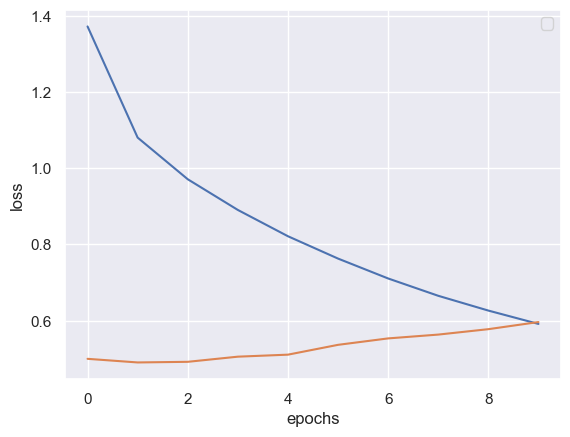

In [142]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [104]:
# greedy approach
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
    result = []

    for i in range(2*max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted

        if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [105]:
#helper function to visualise the attention points that predicts the words
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

few captions generated using Greedy Search vs Beam Search

C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/3273091032_98f724b36b.jpg
BLEU score: 77.8800783071405
Real Caption: <start> there is squirrel sitting up in the grass <end>
Prediction Caption: squirrel sits on the edge of vegetation <end>
time took to Predict: 1 sec


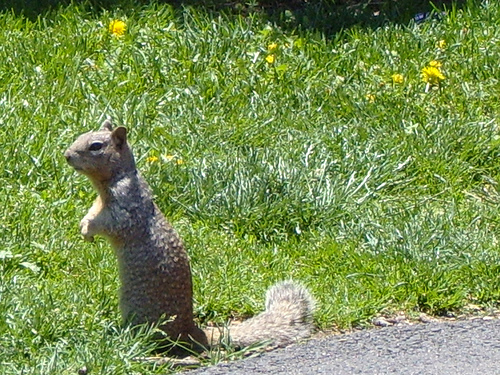

In [106]:
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <unk> from result
result = [word for word in result if word != "<unk>"]

# Join the words in result with space separator
result_join = ' '.join(result)

# Split the real caption into a list of words
real_caption_words = real_caption.split()

# Split the predicted caption into a list of words
predicted_caption_words = result_join.split()

# Calculate BLEU score with unigrams and bigrams
score = sentence_bleu([real_caption_words], predicted_caption_words, weights=(0, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_join)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])


C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/383223174_7165a54c30.jpg
BLEU score: 77.8800783071405
Real Caption: <start> tan dog rests his head in the sand <end>
Prediction Caption: brown dog is running on the dirt <end>
time took to Predict: 1 sec


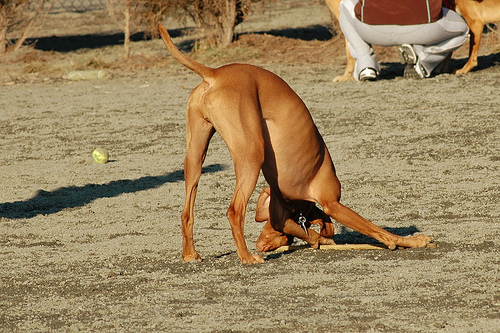

In [200]:
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <unk> from result
result = [word for word in result if word != "<unk>"]

# Join the words in result with space separator
result_join = ' '.join(result)

# Split the real caption into a list of words
real_caption_words = real_caption.split()

# Split the predicted caption into a list of words
predicted_caption_words = result_join.split()

# Calculate BLEU score with unigrams and bigrams
score = sentence_bleu([real_caption_words], predicted_caption_words, weights=(0, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_join)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])


C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/1798209205_77dbf525b0.jpg
BLEU score: 90.48374180359595
Real Caption: <start> woman with tag is pouring red wine in glass <end>
Prediction Caption: blonde woman is eating at table in dim restaurant <end>
time took to Predict: 1 sec


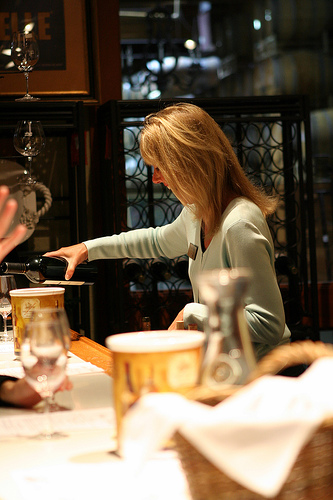

In [203]:
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <unk> from result
result = [word for word in result if word != "<unk>"]

# Join the words in result with space separator
result_join = ' '.join(result)

# Split the real caption into a list of words
real_caption_words = real_caption.split()

# Split the predicted caption into a list of words
predicted_caption_words = result_join.split()

# Calculate BLEU score with unigrams and bigrams
score = sentence_bleu([real_caption_words], predicted_caption_words, weights=(0, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_join)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])


C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/524282699_71e678a6bd.jpg
BLEU score: 86.68778997501818
Real Caption: <start> two dogs running on the sand <end>
Prediction Caption: two dogs run across the beach <end>
time took to Predict: 1 sec


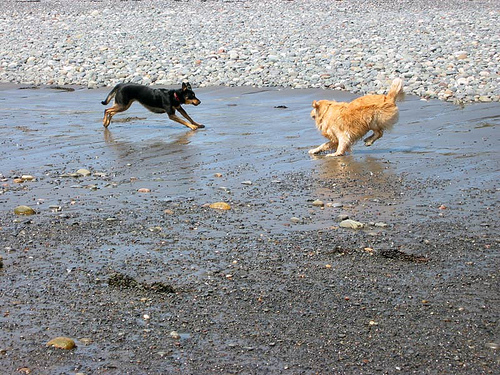

In [206]:
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <unk> from result
result = [word for word in result if word != "<unk>"]

# Join the words in result with space separator
result_join = ' '.join(result)

# Split the real caption into a list of words
real_caption_words = real_caption.split()

# Split the predicted caption into a list of words
predicted_caption_words = result_join.split()

# Calculate BLEU score with unigrams and bigrams
score = sentence_bleu([real_caption_words], predicted_caption_words, weights=(0, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_join)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])


C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/3257182199_5fda78d870.jpg
METEOR score: 43.950913698812855
Real Caption: <start> multiple surfers are out in the ocean waiting for wave <end>
Prediction Caption: surfers line up in the ocean <end>
time took to Predict: 1 sec


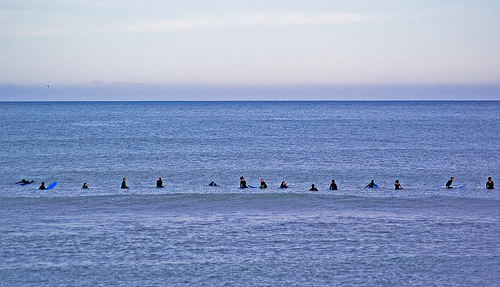

In [184]:
import nltk
#nltk.download('omw-1.4')


from nltk.tokenize import word_tokenize
from PIL import Image
from nltk.translate.meteor_score import meteor_score

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <unk> from result
result = [word for word in result if word != "<unk>"]

# Join the words in result with space separator
result_join = ' '.join(result)

# Tokenize the real caption into a list of words
real_caption_words = word_tokenize(real_caption)

# Tokenize the predicted caption into a list of words
predicted_caption_words = word_tokenize(result_join)

# Calculate METEOR score
score = meteor_score([real_caption_words], predicted_caption_words)
print(f"METEOR score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_join)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])


C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/534655560_dc1c335b3f.jpg
BLEU score: 49.658530379140956
Real Caption: <start> little girl wearing hat playing surrounded by wheelbarrow with wood in the background and building <end>
Prediction Caption: girl in pink hat is walking with his toy <end>
time took to Predict: 1 sec


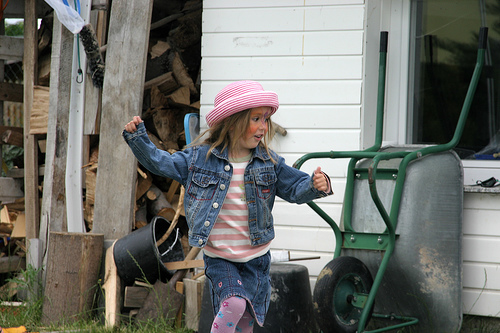

In [146]:
# captions on the training set--greedy search

from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_train))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# Remove <unk> from result
result = [word for word in result if word != "<unk>"]

# Join the words in result with space separator
result_join = ' '.join(result)

# Split the real caption into a list of words
real_caption_words = real_caption.split()

# Split the predicted caption into a list of words
predicted_caption_words = result_join.split()

# Calculate BLEU score with unigrams and bigrams
score = sentence_bleu([real_caption_words], predicted_caption_words, weights=(0, 0, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_join)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])


C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/3257182199_5fda78d870.jpg
BLEU score: 31.321108587083025
Real Caption: surfers are out in the ocean waiting for wave
Prediction Caption: surfers line up in the ocean
time took to Predict: 2 sec


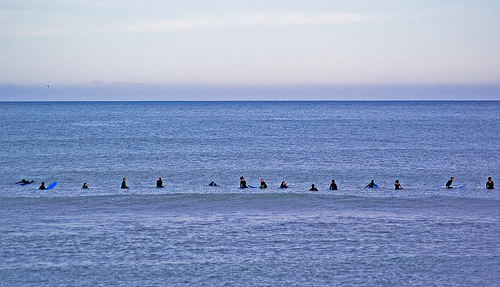

In [219]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))

#image = r"C:\Users\pratd\Downloads\childernonswing.jpeg"
image = r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/3257182199_5fda78d870.jpg"
print(image)
start = time.time()
#real_caption = '<start> a girl playing on swing <end>'
real_caption = '<start>multiple surfers are out in the ocean waiting for wave <end>'
result, attention_plot = evaluate(image)
# result is in this format:  ['woman', 'plays', 'volleyball', '<end>']
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()

from nltk.translate.bleu_score import sentence_bleu
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
#Image.open(r"C:\Users\pratd\Downloads\girlonswing2.jpeg")
#Image.open(r"C:\Users\pratd\Downloads\childernonswing.jpeg")
Image.open(r"C:\Users\pratd\Downloads\Flickr8k_Dataset\Flicker8k_Dataset/3257182199_5fda78d870.jpg")